In [1]:
# Data cleaning
reactions = ["{ } < 'Alkene Addition Elimination, O, H' > { }","{ } < 'Alkene Addition Elimination, O, H' > { }"]
elminate = " {}<>''"
new_reaction = []
for reaction in reactions:
    word = ""
    for character in reaction:
        if character in elminate:
            pass
        else:
            word = word + character 
    new_reaction.append(word)
new_reaction 

['AlkeneAdditionElimination,O,H', 'AlkeneAdditionElimination,O,H']

# Things to add:
* order metbaolites according to order of first occurance
* add name of reactions

**IMPORT DATA**

In [2]:
# Import Data Obtain from MOD
import pickle                    # Import pickle: Binary protocols for serializing and de-serializing a Python object structure.

# PRODUCTS
dbfile = open('products', 'rb')  # Open file in read binary mode    
products = pickle.load(dbfile)   # Import products
dbfile.close()                   # Close connection
# REACTANTS
dbfile = open('reactants', 'rb') # Open file in read binary mode       
reactants = pickle.load(dbfile)  # Import reactants
dbfile.close()                   # Close connection

**PREPARE DATA**

In [3]:
# Get together all molecules to do analysis 
# Reactant Network
network_r = []                           # Initialize a list to store reactants of a network
for reactant in reactants:               # Iterate over the reactants
    for molecule in reactants[reactant]: # Some reactions have more than 1 molecules, iterate over those
        network_r.append(molecule)       # append them to network_r

# Prouct Network
network_p = []                           # Initialize a list to store products of a network
for product in products:                 # Iterate over the products
    for molecule in products[product]:   # Some reactions have more than 1 molecules, iterate over those
        network_p.append(molecule)       # append them to network_p
        
network = network_r + network_p          # create a list containing the TOTAL NETWORK
#network                                 # Uncomment to visualize list 

**DECLARE CANONICAL FUNCTION**

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Descriptors import ExactMolWt
enumerator = rdMolStandardize.TautomerEnumerator()
import os 

def get_canonical(network):
    """ Gets the canonical SMILES strings and Molecule objects of tautomers  in a Network """
        # BASIC NOTATION
    # name  == SMILES string list
    # name_molecule == Molecule object list

    tautomer_molecules =[] # a list that will hold the most stable tautomer
    tautomer = []
    for i in range(0,len(network)):

        mol = Chem.MolFromSmiles(network[i])         # conver to mol object
        can = Chem.MolToSmiles(mol)                  # back to smiles (this will creat canonical strings)
        can_mol=Chem.MolFromSmiles(can)              # convert back to molto see if there are in fact canonical

        taut_mol = enumerator.Canonicalize(can_mol)  # get tautomer (it only works with molecule objects)
        tautomer_molecules.append(taut_mol)          # append to tuatomer_molecules list
        taut = Chem.MolToSmiles(mol)                 # convert to smiles
        tautomer.append(taut)                        # append to tuatomer (SMILES)list
    
    new_tautomer = []
    mol_tautomer = []
    for i in range(0,len(tautomer)):
        sm = Chem.MolToSmiles(tautomer_molecules[i]) #from the mol canoncial objects get the srtings that defined them
        mol_1 = Chem.MolFromSmiles(sm)               # convert back to mol object (this is done in order to get the canonical)
        # 2nd convert back to smiles
        can_1 = Chem.MolToSmiles(mol_1)              # convert them back to string out of mol (to take care of rotated molecules)
        new_tautomer.append(can_1)                   # append this to new_tatuomer
    

    return (new_tautomer)

**QUALITY CHECK**

In [5]:
new_network = get_canonical(network)
A = len(new_network) == len(network)
B = new_network == network
print("List has same size: ",A," List has same content: ",B)
if A == True and B == False:
    print("Test Pass")

List has same size:  True  List has same content:  False
Test Pass


**PROCESS THE DATA AFTER CANONICAL TRANSFORMATION**

In [6]:
new_reactants = new_network[0:len(network_r)] # Obtain a list of the new (canonical) reactants 
new_products  = new_network[len(network_r)::] # Obtain a list of the new (canonical) products 
reac = {}                                     # Create a dictionary to store {reaction_i: [reactant]}
prod = {}                                     # Create a dictionary to store {reaction_i: [product]}
a=0                                           # Variable for slicing 
b=0                                           # Variable for slicing 

# Dictionarize reactants 
for reactant in reactants:                          # Iiterate over reactants (before canonicalization) keys 
        if type(reactants[reactant]) == type("s"):  # If there is only on molecule the dictionary contains a string
            b = b + 1                               #  Add one to final Slicing value
        else:                                       # Else: If dict is not a string, than it is a list, in that case
            b = len(reactants[reactant]) + b        # Add the len of molecules to the final Slicing value

        #print(a,b)
        reac[reactant] = new_reactants[a:b]         # Slice the new_reactants list (canonical reactants) and store it in dic

        if type(reactants[reactant]) == type("s"):  # If there is only on molecule the dictionary contains a string
            a = a + 1                               #  Add one to final Slicing value
        else:
            a = len(reactants[reactant]) + a        # Else: If dict is not a string, than it is a list, in that case

### SAME CODE BUT FOR PRODUCTS ###

a=0                                                 # Reset Variable for slicing 
b=0                                                 # Reset Variable for slicing 
for product in products:
        if type(products[product]) == type("s"):
            b = b + 1
        else:
            b = len(products[product]) + b

        #print(a,b)
        prod[product] = new_products[a:b]

        if type(products[product]) == type("s"):
            a = a + 1
        else:
            a = len(products[product ]) + a


**QUALITY CHECK**

In [7]:
A = len(reac)== len(reactants)
B =  reac == reactants
print(" Reac List has same size: ",A," Reac List has same content: ",B)
A = len(prod)== len(products)
B =  prod == products
print(" Prod List has same size: ",A," Prod List has same content: ",B)
if A == True and B == False:
    print(" Test Pass")

 Reac List has same size:  True  Reac List has same content:  False
 Prod List has same size:  True  Prod List has same content:  False
 Test Pass


**LETS UNDERSTAND OUR FILTERED DATA**

In [8]:
print("MOLECULES:",len(new_network),"UNIQUE MOLECULES:",len(set(new_network)))

MOLECULES: 1795 UNIQUE MOLECULES: 222


In [9]:
# SET() does noy need any order (due to the fact that it was created for mathematical sets), lets do a trick to order nodes
# according to firs appearance (and delete duplicates)
mylist = list(dict.fromkeys(new_network))
len(mylist) 

222

**CREATE A DATA FRAME TO INTIALIZE S**

In [10]:
import pandas as pd
### BUILD THE STOCHIOMETRIC MATRIX ###
# The stochiometric matrix has  metabolites as rows and reactions as  columns

# INTIALIZE THE STOCHIOMETRIC MATRIX 
edges = list(reac.keys())       # Columns representing all the reactions
#nodes  = list(set(new_network)) # Rows representing  unique nodes
nodes = mylist                  # In this format Rows are ordered
S = pd.DataFrame(columns =edges, index=nodes ) # Genereate S
S

,reaction_0,reaction_1,reaction_2,reaction_3,reaction_4,reaction_5,reaction_6,reaction_7,reaction_8,reaction_9,...,reaction_628,reaction_629,reaction_630,reaction_631,reaction_632,reaction_633,reaction_634,reaction_635,reaction_636,reaction_637
OCC1OC(O)C(O)C(O)C1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C=C1OC(O)C(O)C(O)C1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OCC1=CC(O)C(O)C(O)O1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O=C1CC(O)C(O)C(CO)O1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O=C1C(CO)OCC(O)C1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OC(O)C1OC=CC(O)C1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C=C1OC(C(O)C(O)O)C1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OC(O)C(O)C1OC=CC1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C=C1OC1C(O)C(O)C(O)O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
S = S.fillna(0) # Change Nan for 0's 
S

,reaction_0,reaction_1,reaction_2,reaction_3,reaction_4,reaction_5,reaction_6,reaction_7,reaction_8,reaction_9,...,reaction_628,reaction_629,reaction_630,reaction_631,reaction_632,reaction_633,reaction_634,reaction_635,reaction_636,reaction_637
OCC1OC(O)C(O)C(O)C1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C=C1OC(O)C(O)C(O)C1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OCC1=CC(O)C(O)C(O)O1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O=C1CC(O)C(O)C(CO)O1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O=C1C(CO)OCC(O)C1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OC(O)C1OC=CC(O)C1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C=C1OC(C(O)C(O)O)C1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OC(O)C(O)C1OC=CC1O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C=C1OC1C(O)C(O)C(O)O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**LOAD NETWORK INFO TO STOCHIOMETRIC MATRIX**

In [12]:
for reaction_name ,molecules  in zip(reac.keys(), reac.values()):  # Iterate over the reaction names (keys) & molecules (values)
    if len(molecules) == 1:                                        # If the reaction has only 1 reactant 
        S.loc[molecules,reaction_name] = -1                        # add -1 to S matrix in  postion (mol,reaction)
        
    else:                                                          # Else: there are more reactants in the reaction
        for molecule in molecules:                                 # iterate over the molecules
            S.loc[molecule,reaction_name] = -1                     # add -1 to S matrix in  postion (mol,reaction) for every mol

for reaction_name ,molecules in zip(prod.keys(), prod.values()):  # Iterate over the products names (keys) & molecules (values)
    if len(molecules) == 1:                                       # If the reaction has only 1 product
        S.loc[molecules,reaction_name] = 1                        # add 1 to S matrix in  postion (mol,reaction)
        
    else:                                                         # Else: there are more products in the reaction
        for molecule in molecules:                                # iterate over the molecules
            S.loc[molecule,reaction_name] = 1                     # add 1 to S matrix in  postion (mol,reaction) for every mol

**Getting to know Our Matrix**

In [13]:
S.describe()

,reaction_0,reaction_1,reaction_2,reaction_3,reaction_4,reaction_5,reaction_6,reaction_7,reaction_8,reaction_9,...,reaction_628,reaction_629,reaction_630,reaction_631,reaction_632,reaction_633,reaction_634,reaction_635,reaction_636,reaction_637
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.00000,222.00000,...,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,0.004505,0.004505,0.004505,0.004505,0.004505,0.004505,0.004505,0.004505,0.00000,0.00000,...,0.004505,0.004505,0.004505,0.004505,0.004505,0.004505,0.004505,0.004505,0.004505,0.004505
std,0.116423,0.116423,0.116423,0.116423,0.116423,0.116423,0.116423,0.116423,0.09513,0.09513,...,0.116423,0.116423,0.116423,0.116423,0.116423,0.116423,0.116423,0.116423,0.116423,0.116423
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
S_np =  S.to_numpy()
S_np

array([[-1, -1, -1, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

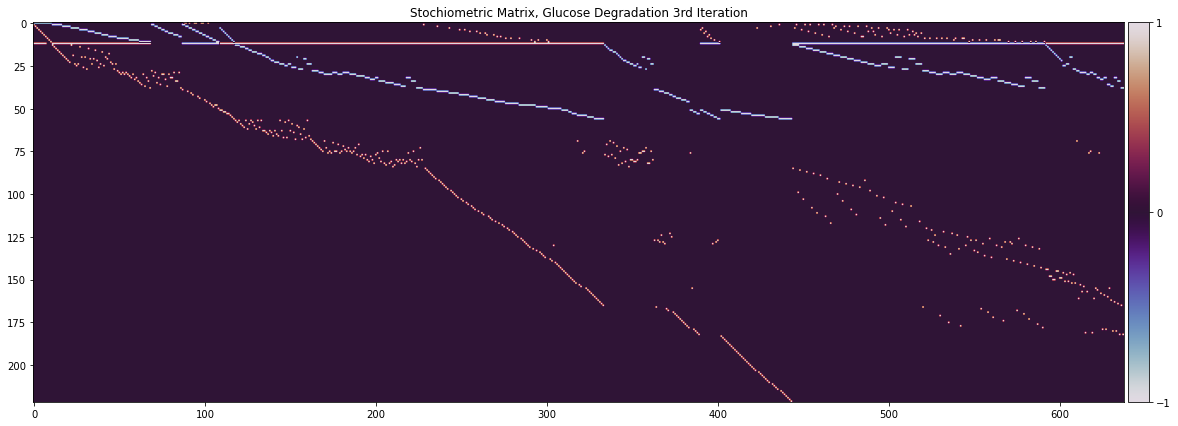

In [15]:
import matplotlib.pyplot as plt                          # Import Matplotllib.pyploy
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Import make_axes_locatabale

fig = plt.figure()                                       # Initalize a  Figure
fig.set_size_inches(20, 20)                              # Set Size
 
ax = plt.gca()                                           # Get the current Axes instance on the current figure, or create one.
ax.set_title("Stochiometric Matrix, Glucose Degradation 3rd Iteration") 
im = ax.imshow(S_np,cmap=plt.cm.twilight)                #  Store plot of Matrix 
divider = make_axes_locatable(ax)                        # Locate axes 
cax = divider.append_axes("right", size="2%", pad=0.05)  # format color bar

#plt.colorbar(im, cax=cax)
plt.colorbar(im,ticks=[-1.0, 0.0, 1.0],cax=cax)          # Plot matrix with color bar
plt.show()          

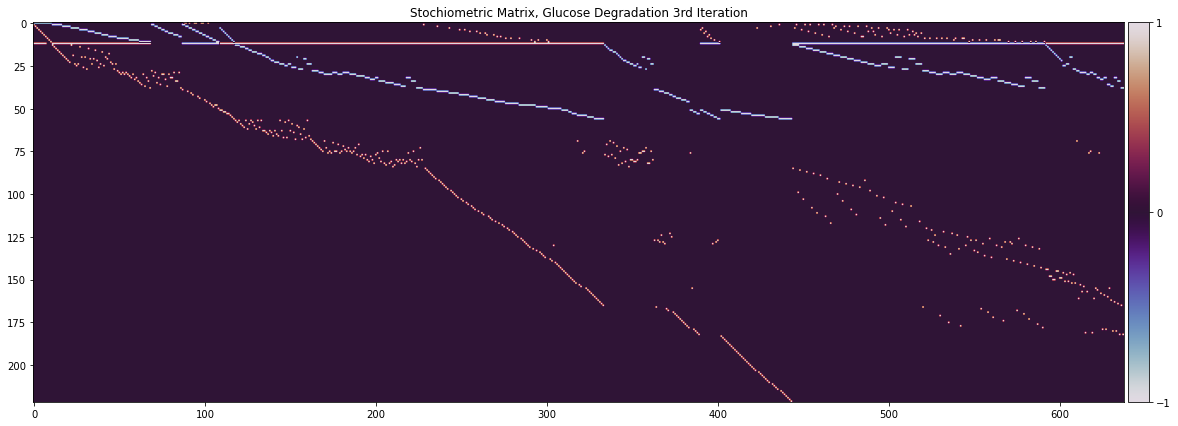

In [29]:
import matplotlib.pyplot as plt                          # Import Matplotllib.pyploy
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Import make_axes_locatabale

fig = plt.figure()                                       # Initalize a  Figure
fig.set_size_inches(20, 20)                              # Set Size
 
ax = plt.gca()                                           # Get the current Axes instance on the current figure, or create one.
ax.set_title("Stochiometric Matrix, Glucose Degradation 3rd Iteration") 
im = ax.imshow(S_np,cmap=plt.cm.twilight)                #  Store plot of Matrix 
divider = make_axes_locatable(ax)                        # Locate axes 
cax = divider.append_axes("right", size="2%", pad=0.05)  # format color bar

#plt.colorbar(im, cax=cax)
plt.colorbar(im,ticks=[-1.0, 0.0, 1.0],cax=cax)          # Plot matrix with color bar
plt.show()     

In [ ]:
a=0
b=0
for i in range(0,10):
    if type(reactants['reaction_0']) == type("s"):
        b = b + 1
    else:
        b = len(reactants['reaction_0']) + b
        
    print(a,b)
    
    if type(reactants['reaction_0']) == type("s"):
        a = a + 1
    else:
        a = len(reactants['reaction_0']) + a